In [62]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

train_data.head() # 훈련용 데이터 헤드 

테스트용 리뷰 개수 : 50000
훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
test_data[:5] # 테스트용 리뷰 다섯개 

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

# 데이터 중복 확인
훈련용 데이터 150000 개 중에 146182를 뺀 3818개가 document에서 중복
훈련용 데이터 labeL 0과 1만 가지므로 2가 출력됨. 

In [4]:
train_data.drop_duplicates(subset=['document'], inplace=True) 
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


# 데이터 중복 제거
document 열에서 중복인 내용 제거 후 총 샘플 수 확인

In [5]:
# null값 확인
print(train_data.isnull().values.any())
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))


True
id          0
document    1
label       0
dtype: int64
False
146182


In [6]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

https://www.unicode.org/charts/PDF/U3130.pdf
ㄱ ~ ㅎ: 3131 ~ 314E
ㅏ ~ ㅣ: 314F ~ 3163

또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.
https://www.unicode.org/charts/PDF/UAC00.pdf



In [7]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data = train_data.dropna(how = 'any')
print(len(train_data))

id            0
document    391
label         0
dtype: int64
145791


In [8]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


# 토큰화

In [9]:
from konlpy.tag import Mecab
tokenizer = Mecab()
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
#데이터 중복 제거
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)    
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


# 정수 인코딩


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [12]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [13]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [14]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [15]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [16]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 빈샘플 제거

In [17]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [18]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
X_train_2 = X_train
X_test_2 = X_test
y_train_2 = y_train
y_test_2 = y_test

X_train_3 = X_train
X_test_3 = X_test
y_train_3 = y_train
y_test_3 = y_test

# 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


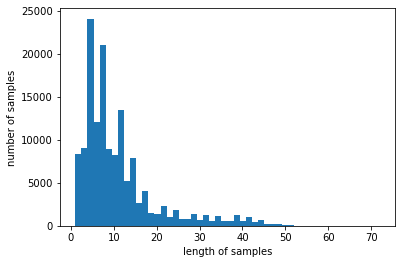

In [20]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [22]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [24]:
X_train = pad_sequences(X_train, padding='pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen = max_len)


# LSTM으로 분류하기

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
epochs=15 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1935/1939 [============================>.] - ETA: 0s - loss: 0.3893 - acc: 0.8229
Epoch 00001: val_acc improved from -inf to 0.84558, saving model to best_model.h5
1939/1939 [==============================] - 14s 7ms/step - loss: 0.3891 - acc: 0.8229 - val_loss: 0.3505 - val_acc: 0.8456
Epoch 2/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3270 - acc: 0.8587
Epoch 00002: val_acc improved from 0.84558 to 0.85717, saving model to best_model.h5
1939/1939 [==============================] - 14s 7ms/step - loss: 0.3270 - acc: 0.8587 - val_loss: 0.3324 - val_acc: 0.8572
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.3020 - acc: 0.8712
Epoch 00003: val_acc improved from 0.85717 to 0.85724, saving model to best_model.h5
1939/1939 [==============================] - 14s 7ms/step - loss: 0.3020 - acc: 0.8712 - val_loss: 0.3345 - val_acc: 0.8572
Epoch 4/15
1933/1939 [============================>.] - ETA: 0s - loss: 0.2836 - acc: 0.8812
Epoc

In [28]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 2s 2ms/step - loss: 0.3442 - acc: 0.8506

 테스트 정확도: 0.8506


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# RNN 분류기

In [91]:
#vocab_size = 100  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 


model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         1941700   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 1,945,269
Trainable params: 1,945,269
Non-trainable params: 0
_________________________________________________________________


In [92]:
print(len(X_train_2))
print(len(y_train_2))

145380
145380


In [93]:
# validation set 30000건 분리
x_val = X_train_2[:30000]   
y_val = y_train_2[:30000]

In [94]:
# validation set을 제외한 나머지 115380건
partial_x_train = X_train_2[30000:]  
partial_y_train = y_train_2[30000:]

In [95]:
print(partial_x_train.shape)
print(partial_y_train.shape)

(115380, 30)
(115380,)


In [96]:
max_len = 30
below_threshold_len(max_len, X_train_2)

#partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
X_test_2 = pad_sequences(X_test_2, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
#y_val = pad_sequences(y_val, maxlen = max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [97]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Epoch 1/20
451/451 [==============================] - 8s 17ms/step - loss: 0.4228 - accuracy: 0.8099 - val_loss: 0.3524 - val_accuracy: 0.8448
Epoch 2/20
451/451 [==============================] - 7s 16ms/step - loss: 0.3193 - accuracy: 0.8643 - val_loss: 0.3482 - val_accuracy: 0.8477
Epoch 3/20
451/451 [==============================] - 8s 17ms/step - loss: 0.2838 - accuracy: 0.8808 - val_loss: 0.3620 - val_accuracy: 0.8464
Epoch 4/20
451/451 [==============================] - 7s 17ms/step - loss: 0.2512 - accuracy: 0.8958 - val_loss: 0.3707 - val_accuracy: 0.8464
Epoch 5/20
451/451 [==============================] - 8s 17ms/step - loss: 0.2204 - accuracy: 0.9106 - val_loss: 0.3949 - val_accuracy: 0.8433
Epoch 6/20
451/451 [==============================] - 8s 17ms/step - loss: 0.1926 - accuracy: 0.9233 - val_loss: 0.4264 - val_accuracy: 0.8431
Epoch 7/20
451/451 [==============================] - 8s 17ms/step - loss: 0.1710 - accuracy: 0.9328 - val_loss: 0.4555 - val_accuracy: 0.8383

In [73]:
results = model.evaluate(X_test_2,  y_test_2, verbose=2)
print(results)

1532/1532 - 3s - loss: 1.1194 - accuracy: 0.8223
[1.1194417476654053, 0.8223084211349487]


In [57]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_2, y_test_2)[1]))


1532/1532 [==============================] - 3s 2ms/step - loss: 0.9467 - accuracy: 0.8230

 테스트 정확도: 0.8230


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN 분류기

In [98]:
x_val = X_train_3[:30000]   
y_val = y_train_3[:30000]
partial_x_train = X_train_3[30000:]  
partial_y_train = y_train_3[30000:]
max_len = 30
below_threshold_len(max_len, X_train_3)

#partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
X_test_3 = pad_sequences(X_test_3, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
#y_val = pad_sequences(y_val, maxlen = max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [105]:
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          310672    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
dense_33 (Dense)             (None, None, 8)           136       
_________________________________________________________________
dense_34 (Dense)             (None, None, 1)           9         
Total params: 312,625
Trainable params: 312,625
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val), 
                    verbose=1)

Epoch 1/20
226/226 [==============================] - 6s 26ms/step - loss: 0.6609 - accuracy: 0.5659 - val_loss: 0.6278 - val_accuracy: 0.5911
Epoch 2/20
226/226 [==============================] - 1s 4ms/step - loss: 0.6142 - accuracy: 0.6035 - val_loss: 0.6223 - val_accuracy: 0.5929
Epoch 3/20
226/226 [==============================] - 1s 4ms/step - loss: 0.6008 - accuracy: 0.6100 - val_loss: 0.6243 - val_accuracy: 0.5932
Epoch 4/20
226/226 [==============================] - 1s 5ms/step - loss: 0.5906 - accuracy: 0.6168 - val_loss: 0.6282 - val_accuracy: 0.5925
Epoch 5/20
226/226 [==============================] - 1s 4ms/step - loss: 0.5817 - accuracy: 0.6209 - val_loss: 0.6348 - val_accuracy: 0.5911
Epoch 6/20
226/226 [==============================] - 1s 5ms/step - loss: 0.5724 - accuracy: 0.6261 - val_loss: 0.6407 - val_accuracy: 0.5920
Epoch 7/20
226/226 [==============================] - 1s 5ms/step - loss: 0.5628 - accuracy: 0.6317 - val_loss: 0.6493 - val_accuracy: 0.5897
Epoch

In [107]:
results = model.evaluate(X_test_3,  y_test_3, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.8535 - accuracy: 0.5816
[0.8535376191139221, 0.5815593600273132]


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Maxpooling 분류기

In [108]:
#vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 4)           77668     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 4)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 9         
Total params: 77,717
Trainable params: 77,717
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val), 
                    verbose=1)

Epoch 1/20
226/226 [==============================] - 1s 3ms/step - loss: 0.6614 - accuracy: 0.7139 - val_loss: 0.5825 - val_accuracy: 0.7843
Epoch 2/20
226/226 [==============================] - 1s 3ms/step - loss: 0.4832 - accuracy: 0.8034 - val_loss: 0.4303 - val_accuracy: 0.8073
Epoch 3/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3998 - accuracy: 0.8295 - val_loss: 0.4047 - val_accuracy: 0.8175
Epoch 4/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3691 - accuracy: 0.8438 - val_loss: 0.3953 - val_accuracy: 0.8231
Epoch 5/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3489 - accuracy: 0.8525 - val_loss: 0.3920 - val_accuracy: 0.8257
Epoch 6/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3342 - accuracy: 0.8601 - val_loss: 0.3923 - val_accuracy: 0.8258
Epoch 7/20
226/226 [==============================] - 1s 3ms/step - loss: 0.3231 - accuracy: 0.8648 - val_loss: 0.3934 - val_accuracy: 0.8262
Epoch 

In [110]:
results = model.evaluate(X_test_3,  y_test_3, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.4513 - accuracy: 0.8151
[0.4513101279735565, 0.815123975276947]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


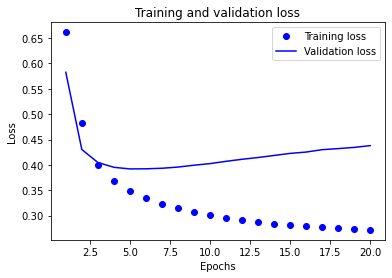

In [111]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

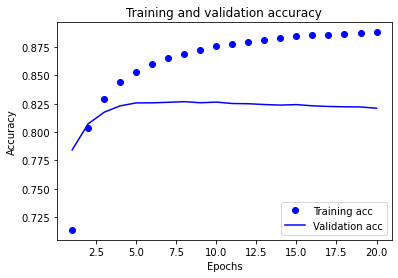

In [112]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# gensim, Word2Vec 불러오기

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import gensim
from konlpy.tag import Okt
import os

In [144]:
ko_model = gensim.models.Word2Vec.load('./aiffel/ko/ko.bin')
a = ko_model.wv.most_similar("사랑")
print(a)

[('슬픔', 0.7216663360595703), ('행복', 0.6759077310562134), ('절망', 0.6468985676765442), ('기쁨', 0.6458414793014526), ('이별', 0.6334798336029053), ('추억', 0.6320937871932983), ('인생', 0.6216273307800293), ('애정', 0.6206068992614746), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


# Word2Vec 만들기

In [145]:
train_data = pd.read_table('./aiffel/ko/ratings.txt')

In [148]:
train_data[:5] 

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [149]:
print(len(train_data))

200000


In [150]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [151]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [152]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [153]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [154]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [156]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [157]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


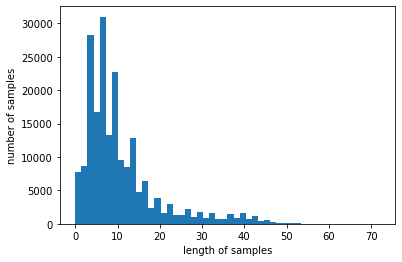

In [158]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [159]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [160]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [161]:
print(model.wv.most_similar("최민식"))


[('한석규', 0.8481477499008179), ('안성기', 0.8302932977676392), ('이정재', 0.8175511360168457), ('단역', 0.8146981000900269), ('베일', 0.8138524889945984), ('김수현', 0.8114380836486816), ('크로우', 0.8098040819168091), ('최민수', 0.8044922947883606), ('양동근', 0.8005156517028809), ('박중훈', 0.7990015745162964)]
